# **Imports**
-----------------------------------------------------------------------------
Main Libraries and modules used throughout out the whole the notebook.

In [ ]:
import os
import cv2
import shutil
import random
import os.path
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras import callbacks
from google.colab import drive
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils.vis_utils import plot_model
from keras.losses import categorical_crossentropy
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, MaxPool2D, Input, GlobalAveragePooling2D, \
    AveragePooling2D, Dropout, Activation, BatchNormalization, concatenate

# **Fetching Dataset and configuring enviroment**
----------------------------------------------------
setting up the project enviroment and fetching the data from kaggle, unzipping it to be ready for usage

 **Creating Content Path to Hold The Project Files**
----------------------------

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

 **Fetching The Dataset From Kaggle**
----------------------------

In [ ]:
!kaggle competitions download -c nn23-sports-image-classification

 99% 260M/262M [00:15<00:00, 20.3MB/s]
100% 262M/262M [00:15<00:00, 17.6MB/s]


 **Unzipping The Dataset Files**
----------------------------

In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle datasets download -d nn23-sports-image-classification.zip
! unzip nn23-sports-image-classification.zip

# **Main Classes**
---------------------
the main classes that will be used througout the whole project

 **Data Preparation and Augmentation Classes**
----------------------------

In [ ]:
class DirectoryManipulator:
    """
        manipulates directories and files

        attributes:
        :param dataPath: the general path
        :param classes: the list of training classes

    """
    def __init__(self, dataPath: str, classes: list) -> None:
        """
        DirectoryManipulator class initializer

        Parameters:
        :param dataPath: the general path
        :param classes: the list of training classes

        Returns:
        :rtype: None
        """
        self.dataPath = dataPath
        self.classes = classes

    @staticmethod
    def initializeDirectory(specPath: str, directoryName: str) -> None:
        """
        creates a new directory at the specified path

        Parameters:
        :param specPath: the path in which the directory will be created
        :param directoryName: the name of the created directory

        Returns:
        :rtype: None
        """
        trainPath = os.path.join(specPath, directoryName)
        os.mkdir(trainPath)

    @staticmethod
    def fillDirectory(sourcePath: str, destPath: str, size: int, className: str = "", move: bool = True) -> None:
        """
        fill destination directory from source directory

        Parameters:
        :param sourcePath: the path of directory that contains the data that will be transferred
        :param destPath: the path of directory that will be filled
        :param size: the number of files
        :param className: the className that will be used to move the file to it's corresponding class directory
        :param move: indicates whether the file will be moved or copied

        Returns:
        :rtype: None
        """
        files = os.listdir(sourcePath)
        if size == -1:
            random.shuffle(files)
            for fileName in files:
                srcPath = os.path.join(sourcePath, fileName)
                if os.path.isfile(srcPath):
                    shutil.copy(srcPath, destPath)
        else:
            stopCounter = 0
            random.shuffle(files)

            for fileName in tqdm(files):
                srcPath = os.path.join(sourcePath, fileName)
                if stopCounter == size:
                    break
                if className.lower() in fileName.lower():
                    if move:
                        shutil.move(srcPath, destPath)
                    else:
                        shutil.copy(srcPath, destPath)
                    stopCounter += 1

    def initializeTVT(self) -> None:
        """
        creates the train, valid and test directories in the general path

        Parameters:
        :param self: DirectoryManipulator class

        Returns:
        :rtype: None
        """
        self.initializeDirectory(self.dataPath, "train")
        self.initializeDirectory(self.dataPath, "valid")
        self.initializeDirectory(self.dataPath, "test")

    def initializeClasses(self) -> None:
        """
        creates the classes directories in each of the TVT directories

        Parameters:
        :param self: DirectoryManipulator class

        Returns:
        :rtype: None
        """
        self.initializeTVT()
        for cls in self.classes:
            self.initializeDirectory(self.dataPath + "/train", cls)
            self.initializeDirectory(self.dataPath + "/valid", cls)
            self.initializeDirectory(self.dataPath + "/test", cls)

    @staticmethod
    def outputResult(testList: list) -> None:
        """
        creates the CSV result file

        Parameters:
        :param testList: the prediction list resulted from a model

        Returns:
        :rtype: None
        """
        seed = random.randint(100000, 999999)
        dataFrame = pd.DataFrame(testList)
        dataFrame.columns = ['image_name', "label"]
        dataFrame.to_csv(f"res{seed}.csv", index=False)

In [ ]:
class Augmentor:
    """
     Augments dataset with various options

     attributes:
     :param sourcePath: the source of the dataset to be augmented
     :param destPath: the destination where the augmented pictures will be saved

    """
    def __init__(self, sourcePath: str, destPath: str) -> None:
        """
        Augmentor class initializer

        Parameters:
        :param sourcePath: the source of the dataset to be augmented
        :param destPath: the destination where the augmented pictures will be saved

        Returns:
        :rtype: None
        """
        self.sourcePath = sourcePath
        self.destPath = destPath

    @staticmethod
    def __setAugOptions(rotationRange: float, wsRange: float, hsRange: float,
                        shearRange: float, zoomRange: float, hFlip: bool, fillMode: str) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        set the options of the produced augmented image

        Parameters:
        :param rotationRange: the range of rotation of the image
        :param wsRange: the wsRange of the image
        :param hsRange: the hsRange of the image
        :param shearRange: the shear range of the image
        :param zoomRange: the zoom range of the image
        :param hFlip: the horizontal range of the image
        :param fillMode: the fill mode of the image

        Returns:
        :rtype: tf.keras.preprocessing.ImageDataGenerator:
        """
        augDataGenerator = tf.keras.preprocessing.image. \
            ImageDataGenerator(rotation_range=rotationRange, width_shift_range=wsRange,
                               height_shift_range=hsRange, shear_range=shearRange, zoom_range=zoomRange,
                               horizontal_flip=hFlip, fill_mode=fillMode)
        return augDataGenerator

    def __generateAugImages(self, imageGenerator: tf.keras.preprocessing.image.ImageDataGenerator, batchSize: int, saveFormat: str, batchNumber: int) -> None:
        """
        generates augmented images

        Parameters:
        :param imageGenerator: the image generator of the augmented images
        :param batchSize: the size of the produced batch
        :param saveFormat: the format of the images that will be saved
        :param batchNumber: the batch production number

        Returns:
        :rtype: None
        """
        path = os.listdir(self.sourcePath)
        for imgName in tqdm(path):
            seed = random.randint(100000, 999999)
            if imgName != 'train' and imgName != 'test' and imgName != 'valid' and imgName != "ppTrain":
                if "aug" not in imgName:
                    img = cv2.imread(f'{self.sourcePath}/{imgName}', 1)
                    npArr = np.array(img)
                    augImgIterator = imageGenerator.flow(x=np.expand_dims(npArr, 0), batch_size=batchSize, save_format=saveFormat)
                    augImg = next(augImgIterator)
                    cv2.imwrite(f'{self.sourcePath}/aug{batchNumber * seed}_{imgName}', augImg[0, :, :, :])

    def generateNAugBatches(self, noOfBatches: int, saveFormat: str, batchSize: int) -> None:
        """
        generates N batches of augmented images

        Parameters:
        :param noOfBatches: the image generator of the augmented images
        :param batchSize: the size of the produced batch
        :param saveFormat: the format of the images that will be saved

        Returns:
        :rtype: None
        """
        breaker = 0
        while breaker < noOfBatches:
            x1 = round(random.uniform(0.1, 0.9), 1)
            x2 = round(random.uniform(0.1, 0.9), 1)
            x3 = round(random.uniform(0.1, 0.9), 1)
            x4 = round(random.uniform(0.1, 0.9), 1)
            x5 = round(random.uniform(0.1, 0.9), 1)
            imgGen = self.__setAugOptions(x1, x2, x3, x4, x5, True, "reflect")
            tqdm(self.__generateAugImages(imgGen, batchSize, saveFormat, breaker + 1))
            breaker += 1

In [ ]:
class PreProcessor:
    """
    split the dataset and generates the Train , valid and test batches

    attributes:
    dataPath: the prediction list resulted from a model
    classes: the train classes of the dataset
    copyDataPath: the directory of the copied dataset
    directoryManipulator: object of the directoryManipulator class

    """
    def __init__(self, dataPath: str, classes: list) -> None:
        """
        preProcessor class initializer

        Parameters:
        :param dataPath: the prediction list resulted from a model
        :param classes: the train classes of the dataset

        Returns:
        :rtype: None
        """
        self.dataPath = dataPath
        self.classes = classes
        self.copyDataPath = ""
        self.directoryManipulator = DirectoryManipulator(self.dataPath, self.classes)

    def __initializeCopyData(self, ppTrainPath: str) -> None:
        """
        creates a copy of the original dataset

        Parameters:
        :param self: preProcessor class initializer
        :param ppTrainPath: the path of the copied dataset

        Returns:
        :rtype: None
        """
        self.directoryManipulator.initializeDirectory(self.dataPath, 'ppTrain')
        self.directoryManipulator.fillDirectory(self.dataPath, ppTrainPath, -1)

    def __createCopyData(self) -> None:
        """
        check if the data is copied or not

        Parameters:
        :param self: preProcessor class initializer

        Returns:
        :rtype: None
        """
        ppTrainPath = os.path.join(self.dataPath, 'ppTrain')
        if os.path.isdir(ppTrainPath) is True:
            shutil.rmtree(os.path.join(self.dataPath, 'ppTrain'))
            self.__initializeCopyData(ppTrainPath)
        else:
            self.__initializeCopyData(ppTrainPath)
        self.copyDataPath = ppTrainPath

    def splitData(self, trainSize: int, validationSize: int, testSize: int) -> None:
        """
        split the data into train, valid and test sets

        Parameters:
        :param self: preProcessor class initializer
        :param trainSize: the percentage of train data
        :param validationSize: the percentage of valid data
        :param testSize: the percentage of test data

        Returns:
        :rtype: None
        """
        self.__createCopyData()
        if os.path.isdir(os.path.join(self.dataPath, 'train')) is True:
            shutil.rmtree(os.path.join(self.dataPath, 'train'))
            shutil.rmtree(os.path.join(self.dataPath, 'valid'))
            shutil.rmtree(os.path.join(self.dataPath, 'test'))
            self.directoryManipulator.initializeClasses()
        else:
            self.directoryManipulator.initializeClasses()
        dataSize = len(os.listdir(self.copyDataPath))
        trainLimit = round(((trainSize * dataSize) / 100) / 6)
        validLimit = round(((validationSize * dataSize) / 100) / 6)
        testLimit = round(((testSize * dataSize) / 100) / 6)
        for cls in self.classes:
            destTrainPath = os.path.join(self.dataPath + '/train', cls)
            destValidPath = os.path.join(self.dataPath + '/valid', cls)
            destTestPath = os.path.join(self.dataPath + '/test', cls)
            self.directoryManipulator.fillDirectory(self.copyDataPath, destTrainPath, trainLimit, cls)
            self.directoryManipulator.fillDirectory(self.copyDataPath, destValidPath, validLimit, cls)
            self.directoryManipulator.fillDirectory(self.copyDataPath, destTestPath,  testLimit, cls)


    def generateTVTBatches(self, imgSize: tuple, trainBatchSize: int,
                           validationBatchSize: int, testBatchSize: int) -> list:
        """
        split the data into train, valid and test sets

        Parameters:
        :param self: preProcessor class initializer
        :param imgSize: the size of img in the batch
        :param trainBatchSize: the size of train data batch
        :param validationBatchSize: the size of valid data batch
        :param testBatchSize: the size of test data batch

        Returns:
        :rtype: list: list of TVT batches
        """
        trainPath = os.path.join(self.dataPath, 'train')
        validPath = os.path.join(self.dataPath, 'valid')
        testPath = os.path.join(self.dataPath, 'test')
        trainBatches = tf.keras.preprocessing.image.ImageDataGenerator(). \
            flow_from_directory(directory=trainPath, target_size=(imgSize[0], imgSize[1]),
                                classes=self.classes, batch_size=trainBatchSize)
        validBatches = tf.keras.preprocessing.image.ImageDataGenerator(). \
            flow_from_directory(directory=validPath, target_size=(imgSize[0], imgSize[1]),
                                classes=self.classes, batch_size=validationBatchSize)
        testBatches = tf.keras.preprocessing.image.ImageDataGenerator(). \
            flow_from_directory(directory=testPath, target_size=(imgSize[0], imgSize[1]),
                                classes=self.classes, batch_size=testBatchSize)
        return [trainBatches, validBatches, testBatches]

 **Models**
----------------------------

In [ ]:
class BasicCNNModel:
    """
    BasicCNNModel with various options

    attributes:
    dataBatches: the optimizer used in the Model
    inputShape: the loss function of the model
    layers: the layers of the model
    """

    def __init__(self, dataBatches: list, inputShape: tuple) -> None:
        """
        BasicCNNModel initializer

        Parameters:
        :param self: BasicCNNModel instance
        :param dataBatches: the optimizer used in the Model
        :param inputShape: the loss function of the model
        Returns:
        :rtype: None
        """
        self.layers = \
            [
                Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=inputShape),
                tf.keras.layers.BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2), strides=2),
                Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                MaxPooling2D(pool_size=(2, 2), strides=2),
                Flatten(),
                Dense(units=6, activation="softmax")
            ]
        self.model = tf.keras.Sequential(self.layers)
        self.batches = dataBatches

    def buildModel(self, optimizer: tf.keras.optimizers, loss: str, metrics: list,
                   epochs: int, verbose: int) -> list:
        """
        compiles and fits the CNN model

        Parameters:
        :param self: BasicCNNModel initializer
        :param optimizer: the optimizer used in the Model
        :param loss: the loss function of the model
        :param metrics: the metrics used as the output
        :param epochs: the number of epochs of training
        :param verbose: the degree clarity of the output

        Returns:
        :rtype: list: the result of the model evaluation
        """
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                         mode="min", patience=5,
                                                         restore_best_weights=True)
        self.model.fit(x=self.batches[0], validation_data=self.batches[1], epochs=epochs, verbose=verbose, callbacks=[earlyStopping])
        results = self.model.evaluate(x=self.batches[2])
        return results


class InceptionV3:
    def __init__(self, inputShape: tuple, noOfClasses: int, dataBatches: list) -> None:
        self.inputShape = inputShape
        self.noOfClasses = noOfClasses
        self.model = self.__BuildInceptionV3Layers()
        self.dataBatches = dataBatches

    def __BuildInceptionV3Layers(self):
        input_layer = Input(shape=self.inputShape)
        x = self.StemBlock(input_layer)
        x = self.__InceptionBlockA(prev_layer=x, nbr_kernels=32)
        x = self.__InceptionBlockA(prev_layer=x, nbr_kernels=64)
        x = self.__InceptionBlockA(prev_layer=x, nbr_kernels=64)
        x = self.__ReductionBlockA(prev_layer=x)
        x = self.__InceptionBlockB(prev_layer=x, nbr_kernels=128)
        x = self.__InceptionBlockB(prev_layer=x, nbr_kernels=160)
        x = self.__InceptionBlockB(prev_layer=x, nbr_kernels=160)
        x = self.__InceptionBlockB(prev_layer=x, nbr_kernels=192)
        x = self.__ReductionBlockB(prev_layer=x)
        x = self.__InceptionBlockC(prev_layer=x)
        x = self.__InceptionBlockC(prev_layer=x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=2048, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        x = Dense(units=self.noOfClasses, activation='softmax')(x)
        model = Model(inputs=input_layer, outputs=x, name='Inception-V3')
        return model

    @staticmethod
    def __convWithBatchNormal(prev_layer, nbr_kernels, filter_Size, strides=(1, 1), padding='same'):
        x = Conv2D(filters=nbr_kernels, kernel_size=filter_Size, strides=strides, padding=padding)(prev_layer)
        x = BatchNormalization(axis=3)(x)
        x = Activation(activation='relu')(x)
        return x

    def StemBlock(self, prev_layer):
        x = self.__convWithBatchNormal(prev_layer, nbr_kernels=32, filter_Size=(3, 3), strides=(2, 2))
        x = self.__convWithBatchNormal(x, nbr_kernels=32, filter_Size=(3, 3))
        x = self.__convWithBatchNormal(x, nbr_kernels=64, filter_Size=(3, 3))
        x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
        x = self.__convWithBatchNormal(x, nbr_kernels=80, filter_Size=(1, 1))
        x = self.__convWithBatchNormal(x, nbr_kernels=192, filter_Size=(3, 3))
        x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
        return x

    def __InceptionBlockA(self, prev_layer, nbr_kernels):
        branch1 = self.__convWithBatchNormal(prev_layer, nbr_kernels=64, filter_Size=(1, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=96, filter_Size=(3, 3))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=96, filter_Size=(3, 3))
        branch2 = self.__convWithBatchNormal(prev_layer, nbr_kernels=48, filter_Size=(1, 1))
        branch2 = self.__convWithBatchNormal(branch2, nbr_kernels=64, filter_Size=(3, 3))  # may be 3*3
        branch3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
        branch3 = self.__convWithBatchNormal(branch3, nbr_kernels=nbr_kernels, filter_Size=(1, 1))
        branch4 = self.__convWithBatchNormal(prev_layer, nbr_kernels=64, filter_Size=(1, 1))
        output = concatenate([branch1, branch2, branch3, branch4], axis=3)
        return output

    def __InceptionBlockB(self, prev_layer, nbr_kernels):
        branch1 = self.__convWithBatchNormal(prev_layer, nbr_kernels=nbr_kernels, filter_Size=(1, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=nbr_kernels, filter_Size=(7, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=nbr_kernels, filter_Size=(1, 7))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=nbr_kernels, filter_Size=(7, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=192, filter_Size=(1, 7))
        branch2 = self.__convWithBatchNormal(prev_layer, nbr_kernels=nbr_kernels, filter_Size=(1, 1))
        branch2 = self.__convWithBatchNormal(branch2, nbr_kernels=nbr_kernels, filter_Size=(1, 7))
        branch2 = self.__convWithBatchNormal(branch2, nbr_kernels=192, filter_Size=(7, 1))
        branch3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
        branch3 = self.__convWithBatchNormal(branch3, nbr_kernels=192, filter_Size=(1, 1))
        branch4 = self.__convWithBatchNormal(prev_layer, nbr_kernels=192, filter_Size=(1, 1))
        output = concatenate([branch1, branch2, branch3, branch4], axis=3)
        return output

    def __InceptionBlockC(self, prev_layer):
        branch1 = self.__convWithBatchNormal(prev_layer, nbr_kernels=448, filter_Size=(1, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=384, filter_Size=(3, 3))
        branch1_1 = self.__convWithBatchNormal(branch1, nbr_kernels=384, filter_Size=(1, 3))
        branch1_2 = self.__convWithBatchNormal(branch1, nbr_kernels=384, filter_Size=(3, 1))
        branch1 = concatenate([branch1_1, branch1_2], axis=3)
        branch2 = self.__convWithBatchNormal(prev_layer, nbr_kernels=384, filter_Size=(1, 1))
        branch2_1 = self.__convWithBatchNormal(branch2, nbr_kernels=384, filter_Size=(1, 3))
        branch2_2 = self.__convWithBatchNormal(branch2, nbr_kernels=384, filter_Size=(3, 1))
        branch2 = concatenate([branch2_1, branch2_2], axis=3)
        branch3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
        branch3 = self.__convWithBatchNormal(branch3, nbr_kernels=192, filter_Size=(1, 1))
        branch4 = self.__convWithBatchNormal(prev_layer, nbr_kernels=320, filter_Size=(1, 1))
        output = concatenate([branch1, branch2, branch3, branch4], axis=3)
        return output

    def __ReductionBlockA(self, prev_layer):
        branch1 = self.__convWithBatchNormal(prev_layer, nbr_kernels=64, filter_Size=(1, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=96, filter_Size=(3, 3))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=96, filter_Size=(3, 3), strides=(2, 2))
        branch2 = self.__convWithBatchNormal(prev_layer, nbr_kernels=384, filter_Size=(3, 3), strides=(2, 2))
        branch3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(prev_layer)
        output = concatenate([branch1, branch2, branch3], axis=3)
        return output

    def __ReductionBlockB(self, prev_layer):
        branch1 = self.__convWithBatchNormal(prev_layer, nbr_kernels=192, filter_Size=(1, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=192, filter_Size=(1, 7))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=192, filter_Size=(7, 1))
        branch1 = self.__convWithBatchNormal(branch1, nbr_kernels=192, filter_Size=(3, 3), strides=(2, 2), padding='valid')
        branch2 = self.__convWithBatchNormal(prev_layer, nbr_kernels=192, filter_Size=(1, 1))
        branch2 = self.__convWithBatchNormal(branch2, nbr_kernels=320, filter_Size=(3, 3), strides=(2, 2), padding='valid')
        branch3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        output = concatenate([branch1, branch2, branch3], axis=3)
        return output

    def buildModel(self, optimizer: tf.keras.optimizers, loss: str, metrics: list,
                   epochs: int, verbose: int, validFreq: int) -> list:
        """
        compiles and fits the inceptionV3 model

        Parameters:
        :param self: BasicCNNModel initializer
        :param optimizer: the optimizer used in the Model
        :param loss: the loss function of the model
        :param metrics: the metrics used as the output
        :param epochs: the number of epochs of training
        :param verbose: the degree clarity of the output
        :param validFreq: the validation frequency of the model

        Returns:
        :rtype: list: the result of the model evaluation
        """
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        tqdm(self.model.fit(x=self.dataBatches[0], validation_data=self.dataBatches[1], epochs=epochs, verbose=verbose, validation_freq=validFreq))
        results = self.model.evaluate(x=self.dataBatches[2])
        return results

In [ ]:
class ModelTester:
    """
    tests a given model and generates results compared to a test data
    """
    @staticmethod
    def __initializeTestFolder(testPath: str, destPath: str) -> None:
        """
        creates a test directory which will be used by the test generator

        Parameters:
        :param testPath: the path of the test directory
        :param destPath: the path in which the test directory will be created

        Returns:
        :rtype: None
        """
        DirectoryManipulator.initializeDirectory(testPath, 'test')
        DirectoryManipulator.fillDirectory(testPath, destPath, -1)

    @staticmethod
    def __checkPredictions(predictions: list, unlabeledTestBatches: tf.keras.preprocessing.image.ImageDataGenerator) -> list:
        """
        matches the prediction names with test results of the model and generates the results CSV file

        Parameters:
        :param predictions: the predictions list
        :param unlabeledTestBatches: the image generator of the test path
        Returns:
        :rtype: list: the result of the model predictions
        """
        normalizePredictions = []
        fileNameList = []
        fileCounter = 0
        print(predictions)
        print(len(predictions))
        for prediction in predictions:
            fileName = unlabeledTestBatches.filenames[fileCounter]
            fileNameList.append(fileName.split('/')[1])
            normalizePredictions.append(np.argmax(prediction))
            fileCounter += 1
        testList = np.dstack((np.array(fileNameList), np.array(normalizePredictions))).reshape(-1, 2)
        DirectoryManipulator.outputResult(testList=testList)
        return testList

    def testModel(self, testPath: str, imgSize: tuple, batchSize: int, model: tf.keras.models, isMultiLayer: bool, batches: list) -> list:
        """
        tests the model

        Parameters:
        :param testPath: the path of the test
        :param imgSize: the size of the test image size
        :param batchSize: the batch size of test generator

        Returns:
        :rtype: list: the result of the model predictions
        """
        destPath = os.path.join(testPath, 'test')
        if os.path.isdir(destPath) is True:
            shutil.rmtree(destPath)
            self.__initializeTestFolder(testPath, destPath)
        else:
            self.__initializeTestFolder(testPath, destPath)
        unlabeledTestBatches = tf.keras.preprocessing.image.ImageDataGenerator(). \
            flow_from_directory(directory=testPath, target_size=imgSize, batch_size=batchSize, shuffle=False)
        predictions = model.predict(unlabeledTestBatches)
        testAccuracy = model.evaluate(x=batches[2])
        results = []
        results.append(testAccuracy)
        if isMultiLayer:
            for layerPrediction in predictions:
                results.append(self.__checkPredictions(layerPrediction, unlabeledTestBatches))
            return results
        else:
            return [testAccuracy, self.__checkPredictions(predictions, unlabeledTestBatches)]

    @staticmethod
    def modelCSVAccuracy(testFile: str, testedFile: str) -> float:
        """
        return the accuracy of the model based on csv files

        Parameters:
        :param testFile: the name of the test file
        :param testedFile: the name of the tested file

        Returns:
        :rtype: the model accuracy
        """
        df1 = pd.read_csv(testFile)
        df1 = df1.sort_values('image_name')
        df2 = pd.read_csv(testedFile)
        df2 = df2.sort_values('image_name')
        accuracy = 0
        for i in df1.index:
            x = df1.iloc[i, 1]
            y = df2.iloc[i, 1]
            if x == y:
                accuracy += 1
        return accuracy * 100 / 688

    @staticmethod
    def modelAccuracy(testPath: str, batchSize: int, noOfClasses: int, imgSize: tuple, model: tf.keras.models) -> float:
        """
        return the accuracy of the model

        Parameters:
        :param testPath: the path of the test
        :param batchSize: the size of the batch
        :param noOfClasses: the number of classes of the model
        :param imgSize: the size of the image
        :param model: the model that will be tested

        Returns:
        :rtype: float: the model accuracy
        """
        data = tf.keras.utils.image_dataset_from_directory(testPath, batch_size=batchSize, image_size=imgSize)
        dataIter = data.as_numpy_iterator()
        accuracy = 0

        def convert(batchS, nClasses, btch):
            array = np.zeros((batchS, nClasses))
            for j in range(len(btch[1])):
                array[j, btch[1][j]] = 1
            return array

        for i in range(len(data) - 1):
            batch = dataIter.next()
            result = model.evaluate(x=batch[0], y=convert(batchSize, noOfClasses, batch))
            accuracy += result[1]
        return accuracy / len(data)

# **Preproccessing and Dataset Augmentation**
-------------------------------------------------
applying necessary operations on the dataset to obtain best results

 **Applying Data Augmentation On The Dataset**
----------------------------

In [ ]:
sPath = r"/content/Train"
dPath = r"/content/Train"
dataClasses = ['basketball', 'football', 'rowing', 'swimming', 'tennis', 'yoga']
# Augmentor = Augmentor(sourcePath=sPath, destPath=dPath)
# Augmentor.generateNAugBatches(1, 'png', 2)

 **Applying Data Preprocessing and splitting the Dataset**
----------------------------

In [ ]:
path = "/content/Train"
dataClasses = ['basketball', 'football', 'rowing', 'swimming', 'tennis', 'yoga']
p1 = PreProcessor(path, dataClasses)
p1.splitData(90, 5, 5)
batches = p1.generateTVTBatches((299, 299), 10, 10, 10)

  5%|▌         | 17/312 [00:00<00:00, 18208.16it/s]


Found 1327 images belonging to 6 classes.
Found 28 images belonging to 6 classes.
Found 28 images belonging to 6 classes.


# **Basic CNN Model**
-------------------------------------------------
The building, training and testing of the Basic CNN Model

 **Building the Basic CNN architecture**
----------------------------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_95 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_97 (Conv2D)          (None, 149, 149, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                      

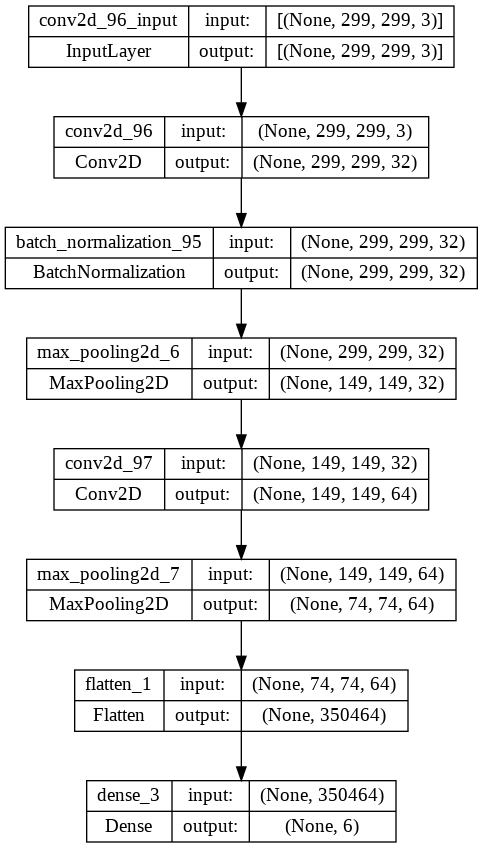

In [ ]:
CNN = BasicCNNModel(batches, (299, 299, 3))
print(CNN.model.summary())
plot_model(CNN.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

 **Training Basic CNN**
----------------------------

In [ ]:
tqdm(CNN.buildModel(Adam(learning_rate=0.001), "categorical_crossentropy", ['accuracy'], 5, 2))

Epoch 1/5
133/133 - 12s - loss: 13.5033 - accuracy: 0.5252 - val_loss: 5.8928 - val_accuracy: 0.6071 - 12s/epoch - 90ms/step
Epoch 2/5
133/133 - 9s - loss: 0.8306 - accuracy: 0.8659 - val_loss: 4.9502 - val_accuracy: 0.6071 - 9s/epoch - 67ms/step
Epoch 3/5
133/133 - 8s - loss: 0.2014 - accuracy: 0.9435 - val_loss: 2.8214 - val_accuracy: 0.6071 - 8s/epoch - 64ms/step
Epoch 4/5
133/133 - 9s - loss: 0.0828 - accuracy: 0.9721 - val_loss: 3.7213 - val_accuracy: 0.6429 - 9s/epoch - 66ms/step
Epoch 5/5
133/133 - 9s - loss: 0.0104 - accuracy: 0.9962 - val_loss: 2.9423 - val_accuracy: 0.6429 - 9s/epoch - 65ms/step
3/3 [==============================] - 0s 42ms/step - loss: 1.0350 - accuracy: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

 **Testing Basic CNN**
----------------------------

In [ ]:
tstPath = r"/content/Test"
tester = ModelTester()
CNNRes = tester.testModel(tstPath, (299, 299), 20, CNN.model, False, batches)

Found 688 images belonging to 1 classes.
3/3 [==============================] - 0s 78ms/step - loss: 1.0350 - accuracy: 0.7500
[[2.6516871e-06 1.6606102e-06 4.4772424e-08 2.5590063e-10 9.9999559e-01
  2.3005155e-11]
 [4.3835863e-01 8.5913009e-05 5.9455945e-03 4.3412831e-02 3.8694918e-01
  1.2524785e-01]
 [7.7742210e-05 3.0654920e-02 9.6449393e-01 3.1230325e-04 2.0662781e-03
  2.3948443e-03]
 ...
 [3.7710594e-03 1.4166986e-06 9.9614775e-01 2.5945601e-05 5.3902429e-05
  4.0796919e-12]
 [8.2362449e-01 9.5077406e-04 6.7490087e-06 3.3775618e-04 1.7496169e-01
  1.1845010e-04]
 [9.9355233e-01 2.9216958e-03 1.6647797e-03 2.3308265e-04 1.6279251e-03
  1.2172866e-07]]
688


In [ ]:
print(f"The loss function of Basic CNN Model : {CNNRes[0][0]} and it's Accuracy : {CNNRes[0][1]}%")

The loss function of Basic CNN Model : 1.034993290901184 and it's Accuracy : 0.75%


In [ ]:
tester.modelCSVAccuracy(testFile="new.csv", testedFile="res.csv")

70.34883720930233

# **InceptionV3 Model**
-------------------------------------------------
The building, training and testing of the Basic InceptionV3 Model

 **Building the InceptionV3 architecture**
----------------------------

In [ ]:
incModel = InceptionV3((299, 299, 3), 6, batches)
print(incModel.model.summary())

In [ ]:
plot_model(incModel.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

 **Training InceptionV3 Model**
----------------------------

In [ ]:
incModel.buildModel('adam', 'categorical_crossentropy', ['accuracy'], 5, 2, 1)

In [ ]:
incModel.buildModel('adam', 'categorical_crossentropy', ['accuracy'], 5, 2, 1)

 **Testing InceptionV3**
----------------------------

In [ ]:
tstPath = r"/content/Test"
tester = ModelTester()
incRes = tester.testModel(tstPath, (299, 299), 20, incModel.model, False, batches)

In [ ]:
print(f"The loss function of InceptionV3 Model : {incRes[0][0]} and it's Accuracy : {incRes[0][1]}%")

The loss function of InceptionV3 Model : 1.3618913888931274 and it's Accuracy : 0.6428571343421936%


In [ ]:
tester.modelCSVAccuracy(testFile="new.csv", testedFile="res.csv")

28.343023255813954

# **Loaded InceptionV3 Model**
-----------------------------
The loading and testing of a loaded Pretrained InceptionV3 Model

 **loading the model**
----------------------------

In [ ]:
loadedModel = r"/content/drive/MyDrive/incModel"
model = tf.keras.models.load_model(loadedModel)

In [ ]:
print(model.summary())

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

 **Testing the model**
----------------------------

In [ ]:
tstPath = r"/content/Test"
incRes = tester.testModel(tstPath, (299, 299), 20, model, True, batches)

In [ ]:
print(f"The loss function of Loaded InceptionV3 Model : {incRes[0][0]} and it's Accuracy : {incRes[0][3]*100}%, {incRes[0][4]*100}%")

The loss function of Loaded InceptionV3 Model : 0.1262361854314804 and it's Accuracy : 100.0%, 96.42857313156128%


In [ ]:
tester.modelCSVAccuracy(testFile="new.csv", testedFile="res238910.csv")

78.77906976744185

In [ ]:
tester.modelCSVAccuracy(testFile="new.csv", testedFile="res743735.csv")

80.52325581395348

In [ ]:
from keras.applications.mobilenet_v3 import models
from keras.layers import Dense, Activation, Flatten
from keras import *
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
model=Sequential()
model.add(VGG16(include_top=False,pooling='avg',weights='imagenet',))

for layer in model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

x = layers.Dense(6, activation='sigmoid')(x)

model = tf.keras.models.Model(model.input, x)



In [ ]:
model.compile(optimizer ='adam', loss = 'categorical_crossentropy',metrics = ['acc'])
vgghist = model.fit(batches[0], validation_data = batches[1], steps_per_epoch = 40, epochs = 10)


Epoch 1/10
40/40 [==============================] - 6s 137ms/step - loss: 1.1085 - acc: 0.8075 - val_loss: 0.2691 - val_acc: 0.9286
Epoch 2/10
40/40 [==============================] - 5s 135ms/step - loss: 1.0361 - acc: 0.7850 - val_loss: 0.4184 - val_acc: 0.9286
Epoch 3/10
40/40 [==============================] - 5s 130ms/step - loss: 0.7036 - acc: 0.8564 - val_loss: 0.2805 - val_acc: 0.9286
Epoch 4/10
40/40 [==============================] - 5s 135ms/step - loss: 0.5764 - acc: 0.8700 - val_loss: 0.7078 - val_acc: 0.8929
Epoch 5/10
40/40 [==============================] - 5s 133ms/step - loss: 0.4119 - acc: 0.9125 - val_loss: 0.3942 - val_acc: 0.9286
Epoch 6/10
40/40 [==============================] - 5s 132ms/step - loss: 0.3650 - acc: 0.9118 - val_loss: 0.2725 - val_acc: 0.9286
Epoch 7/10
40/40 [==============================] - 6s 138ms/step - loss: 0.4005 - acc: 0.9050 - val_loss: 0.2304 - val_acc: 0.9286
Epoch 8/10
40/40 [==============================] - 5s 128ms/step - loss: 0.